# Clean Bitfinex data

This script cleans Bitfinex data to write to disk, and does some analysis of the missingness of the data.

## Import libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
from datetime import *
from tqdm import tqdm

# Data: https://www.kaggle.com/tencars/392-crypto-currency-pairs-at-minute-resolution

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/Shared drives/MS&E 448 Power Group')

Mounted at /content/drive


Specify the read/write paths:

In [ ]:
read_data_path = './Datasets/bitfinex/'
write_data_path = './Datasets/bitfinex_cleaned/minute/'

## Write function to clean the data

In [ ]:
# Description: this function takes raw data and imputes data for missing time rows.
# According to the documentation (see first code chunk), missing rows indicates
# either that the exchange was down and/or no trades were made. Thus for missing rows,
# we impute the last close price for the open, high, low and close columns, and
# put 0 for volume.
#
# param currency_pair: the currency pair to clean (i.e., impute missing data for)
# returns perc_not_missing: percentage of data not missing by year
# returns df2: cleaned dataframe
def clean_data(currency_pair, freq='1min', hourly_missingness=False):

  # Load data
  data_path = read_data_path+currency_pair+'.csv'
  df = pd.read_csv(data_path)
  df['time'] = df['time'].map(lambda ts: datetime.utcfromtimestamp(ts/1000))

  # If checking hourly missingness, run this:
  if hourly_missingness and len(df.index) > 0:
    df['minutes'] = df.time.dt.minute
    df['offset'] = pd.to_timedelta(df.apply(lambda x: x.minutes if x.minutes in [58, 59, 0, 1, 2] else 0, axis=1), unit='min')
    df['time'] = df['time'] - df['offset']
    df = df.drop_duplicates('time')

  # Create missing time rows
  full_idx = pd.date_range(start='2013-01-01', end='2021-04-21', freq=freq)
  df2 = df.set_index('time').reindex(full_idx).reset_index().rename({'index':'time'},axis=1)

  # Calculate percentage of time rows not missing
  perc_not_missing = df2.groupby(df2.time.dt.to_period("Y")).apply(lambda x: x['close'].count()/x['time'].count())

  # Fill missing time rows
  df2['close'].ffill(inplace=True)
  df2['open'].fillna(df2['close'], inplace=True)
  df2['high'].fillna(df2['close'], inplace=True)
  df2['low'].fillna(df2['close'], inplace=True)
  df2['volume'].fillna(0, inplace=True)
  # Add this line if you want unix time as a column
  # df2['unixtimestamp'] = (df2['time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

  return df2, perc_not_missing

In [ ]:
# # Print all pairs with USD
# count = 0
# for filename in os.listdir(read_data_path):
#   if filename[-7:-4] == 'usd':
#     print(filename[:-4])
#     count +=1
# print(count)

## Clean and save the data for top pairs at CoinMarketCap

I chose the top 6 coins from https://coinmarketcap.com/ by volume and market cap that were available in Bitfinex, and also plotted their availability (aka non-missingness).

In [ ]:
pairs = ['btcusd','ethusd','xrpusd','dogusd','ltcusd','adausd'] # change this as you please

perc_not_missing_dict = {}

for currency_pair in tqdm(pairs):
    cleaned_data, perc_not_missing = clean_data(currency_pair)
    cleaned_data.to_csv(write_data_path+currency_pair+'.csv')
    perc_not_missing.to_csv(write_data_path+currency_pair+'_perc_not_missing.csv')
    perc_not_missing_dict[currency_pair] = perc_not_missing

100%|██████████| 6/6 [03:56<00:00, 39.43s/it]


## Analyse missingness of the data

It seems that BTC, ETH and XRP have high availability and would be good to start with.

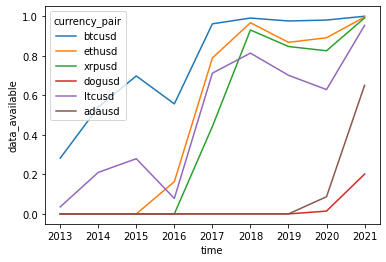

In [ ]:
p = pd.DataFrame.from_dict(perc_not_missing_dict).reset_index()
p = pd.melt(p, id_vars=['time'], var_name='currency_pair', value_name='data_available')
p['time'] = p['time'].astype('str').astype('int')
sns.lineplot(data=p, x="time", y="data_available", hue="currency_pair")

## Clean and save data for all 343 currency pairs

In [ ]:
perc_not_missing_dict = {}

In [ ]:
# This step takes about 3 hours and may require restarting this cell if Colab disconnects

already_saved = [x for x in os.listdir(write_data_path)]

getattr(tqdm, '_instances', {}).clear()
pbar = tqdm(os.listdir(read_data_path), desc='Cleaning and saving data')

for filename in pbar:
  pbar.set_postfix_str(filename)
  if filename not in already_saved:
    currency_pair = filename[:-4]
    cleaned_data, perc_not_missing = clean_data(currency_pair)
    cleaned_data.to_csv(write_data_path+currency_pair+'.csv')
    perc_not_missing.to_csv(write_data_path+currency_pair+'_perc_not_missing.csv')
    perc_not_missing_dict[currency_pair] = perc_not_missing

Cleaning and saving data: 100%|██████████| 343/343 [2:28:17<00:00, 25.94s/it, zrxusd.csv]


In [ ]:
len(perc_not_missing_dict)

343

The below is a quick analysis of finding all currency pairs whose non-missingness percentage is above 60% for 2019, 2020 and 2021. Only 5 pairs match this criteria. Three (btcusd, ethusd and xrpusd) are the most promising and also concur with what was found on CoinMarketCap as seen in the analysis above.

In [ ]:
perc_not_missing_dict_subset = {}
for pair, ts in perc_not_missing_dict.items():
  if min(ts['2019'],ts['2020'],ts['2021']) > 0.6:
    perc_not_missing_dict_subset[pair] = ts

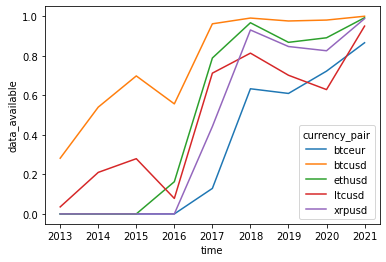

In [ ]:
p = pd.DataFrame.from_dict(perc_not_missing_dict_subset).reset_index()
p = pd.melt(p, id_vars=['time'], var_name='currency_pair', value_name='data_available')
p['time'] = p['time'].astype('str').astype('int')
sns.lineplot(data=p, x="time", y="data_available", hue="currency_pair")

## Analysing missingness at the hourly level

First look at missingness at the exact hourly timestamps.

In [ ]:
perc_not_missing_dict_hourly = {}

In [ ]:
# This step takes about 5 minutes and may require restarting this cell if Colab disconnects

already_computed = [k for k,v in perc_not_missing_dict_hourly.items()]

getattr(tqdm, '_instances', {}).clear()
pbar = tqdm(os.listdir(read_data_path), desc='Generating hourly perc_not_missing data')

for filename in pbar:
  pbar.set_postfix_str(filename)
  currency_pair = filename[:-4]
  if currency_pair not in already_computed:
    cleaned_data, perc_not_missing = clean_data(currency_pair, freq='H')
    perc_not_missing_dict_hourly[currency_pair] = perc_not_missing

Generating hourly perc_not_missing data: 100%|██████████| 343/343 [03:29<00:00,  1.64it/s, zrxusd.csv]


In [ ]:
perc_not_missing_dict_hourly_subset = {}
for pair, ts in perc_not_missing_dict_hourly.items():
  if min(ts['2019'],ts['2020'],ts['2021']) > 0.6:
    perc_not_missing_dict_hourly_subset[pair] = ts

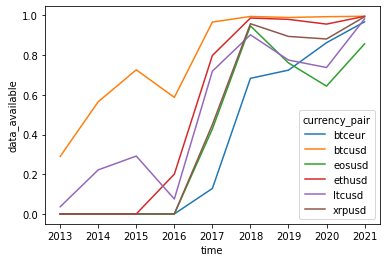

In [ ]:
p = pd.DataFrame.from_dict(perc_not_missing_dict_hourly_subset).reset_index()
p = pd.melt(p, id_vars=['time'], var_name='currency_pair', value_name='data_available')
p['time'] = p['time'].astype('str').astype('int')
sns.lineplot(data=p, x="time", y="data_available", hue="currency_pair")

Next, consider data +/- 2 mins from the exact hourly timestamp as close enough to hourly timestamps to be considered such.

In [ ]:
perc_not_missing_dict_hourly2 = {}

In [ ]:
# This step takes about 5 minutes and may require restarting this cell if Colab disconnects

already_computed = [k for k,v in perc_not_missing_dict_hourly2.items()]

getattr(tqdm, '_instances', {}).clear()
pbar = tqdm(['btceur','btcusd','eosusd','ethusd','ltcusd','xrpusd'], desc='Generating hourly perc_not_missing data')

for currency_pair in pbar:
  pbar.set_postfix_str(currency_pair)
  if currency_pair not in already_computed:
    cleaned_data, perc_not_missing = clean_data(currency_pair, freq='H', hourly_missingness=True)
    perc_not_missing_dict_hourly2[currency_pair] = perc_not_missing

Generating hourly perc_not_missing data: 100%|██████████| 6/6 [03:37<00:00, 36.21s/it, xrpusd]


In [ ]:
perc_not_missing_dict_hourly2_subset = {}
for pair, ts in perc_not_missing_dict_hourly2.items():
  if min(ts['2019'],ts['2020'],ts['2021']) > 0.6:
    perc_not_missing_dict_hourly2_subset[pair] = ts

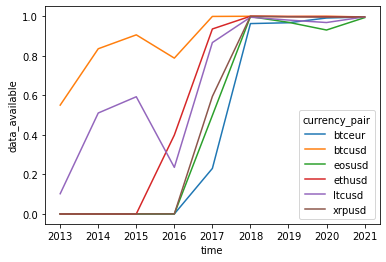

In [ ]:
p = pd.DataFrame.from_dict(perc_not_missing_dict_hourly2_subset).reset_index()
p = pd.melt(p, id_vars=['time'], var_name='currency_pair', value_name='data_available')
p['time'] = p['time'].astype('str').astype('int')
sns.lineplot(data=p, x="time", y="data_available", hue="currency_pair")

## Create files for hourly data

In [ ]:
read_data_path = './Datasets/bitfinex_cleaned/minute/'
write_data_path = './Datasets/bitfinex_cleaned/hour/'

In [ ]:
def get_freq_data(currency_pair, freq='H'):
  # Load data
  data_path = read_data_path+currency_pair+'.csv'
  df = pd.read_csv(data_path, parse_dates=['time'])

  # Take hourly data
  full_idx = pd.date_range(start='2013-01-01', end='2021-04-21', freq=freq)
  df2 = df.set_index('time').reindex(full_idx).reset_index().rename({'index':'time'},axis=1)

  return df2

In [ ]:
already_saved = []

In [ ]:
# This step takes about 1 hour and may require restarting this cell if Colab disconnects

already_saved = [x for x in os.listdir(write_data_path)]

getattr(tqdm, '_instances', {}).clear()
pbar = tqdm(os.listdir(read_data_path), desc='Converting to hourly data')

for filename in pbar:
  pbar.set_postfix_str(filename)
  if filename not in already_saved and 'perc_not_missing' not in filename:
    currency_pair = filename[:-4]
    hourly_data = get_freq_data(currency_pair, freq='H')
    hourly_data.to_csv(write_data_path+currency_pair+'_hourly.csv')

Converting to hourly data: 100%|██████████| 686/686 [43:27<00:00,  3.80s/it, unif0ustf0.csv]
